# Momentum Strategies

# 1. READING - The Momentum Product
This section is not graded, and you do not need to submit your answers. But you are expected to consider these issues and be ready to discuss them.

### 1.1 
What is novel about the AQR Momentum product under construction compared to the various momentum investment products already offered?

### 1.2 
Name three reasons the momentum investment product will not exactly track the momentum index, (ie. why the strategy will have tracking error.)

### 1.3 
When constructing the momentum portfolio, AQR ranks stocks on their returns from month $t-12$ through $t-2$. Why don't they include the $t-1$ return in this ranking?

# 2. Investigating Momentum

### Data

In this section, we empirically investigate some concerns regarding AQR's new momentum product.
On Canvas, find the data file, `data/momentum_data.xlsx`.

* The first tab contains the momentum factor as an excess return: $\tilde{r}^{\mathrm{mom}}$.
* The second tab contains returns on portfolios corresponding to scored momentum deciles.
  - $r^{\operatorname{mom}(1)}$ denotes the portfolio of stocks in the lowest momentum decile, the "losers" with the lowest past returns.
  - $r^{\operatorname{mom}(10)}$ denotes the portfolio of stocks in the highest momentum decile.
* The third tab gives portfolios sorted by momentum and size.
  - $r^{\text {momsu }}$ denotes the portfolio of small stocks in the top 3 deciles of momentum scores.
  - $r^{\text {momBD }}$ denotes the portfolio of big-stocks in the bottom 3 deciles of momentum scores.

Note that the Fama-French momentum return, $\tilde{r}^{\mathrm{mom}: \mathrm{FF}}$, given in the first tab, is constructed by $\mathrm{FF}$ as,

$$
\tilde{r}^{\mathrm{mom}: \mathrm{FF}}=\frac{1}{2}\left(r^{\mathrm{momBU}}+r^{\mathrm{momSU}}\right)-\frac{1}{2}\left(r^{\mathrm{momBD}}+r^{\mathrm{momSD}}\right)
$$

The Fama-French momentum return

$$\tilde{r}^{mom:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − \frac{1}{2} (\tilde{r}^{momBD} + \tilde{r}^{momSD}) $$

### 2.1 Is Momentum sill profitable?

The excess returns of lucrative trading strategies often disappear once the strategy is well-known. The first widely-cited paper on momentum was published in 1993. Have momentum returns or risk changed since then? The AQR case takes place at the end of 2008. Have momentum returns changed in 2009-2024?

Investigate by filling out the summary statistics below for the full-sample and three sub-samples.

#### (a) 
Using the data provided, fill in Table 1 with the appropriate stats for $\tilde{r}^{\text {mom:FF }}$.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 2: Long-only momentum performance. }\\
&\begin{array}{llllll}
\hline \hline \text { Subsample } \quad \text { mean } \quad \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline & & & & \\
1927-2024 & & & \\
1927-1993 & & & \\
1993-2008 & & & \\
2009-2024 & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation*}
$$

#### (b)
Has momentum changed much over time, as seen through these subsample statistics?

#### (c) 

Does this data support AQR's argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs - would there still be evidence here that momentum is valuable?

In [3]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import statsmodels.api as sm

In [4]:
#Question 2.1 a) 
path='../data/momentum_data.xlsx'
sheet='momentum (excess returns)'

xl = pd.ExcelFile(path)
tab1 = xl.parse(xl.sheet_names[1])
tab2 = xl.parse(xl.sheet_names[2])

# ensure Date is datetime in both
for df in (tab1, tab2):
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# merge Tab 2 -> Tab 1 (left-join) and keep result in memory
base = tab1.merge(tab2, on='Date', how='left', suffixes=('', '_tab2'))

date=base['Date']
m1 = (date.dt.year >= 1927) & (date.dt.year <= 1993)
m2 = (date.dt.year >= 1993) & (date.dt.year <= 2008)
m3 = (date.dt.year >= 2009) & (date.dt.year <= 2024)

subset_1=base.loc[m1]
subset_2=base.loc[m2]
subset_3=base.loc[m3]

def calc_summary_statistics(
        returns: pd.DataFrame,
        annual_factor: int = 12,
        corr_cols: tuple[str, str] = ("MKT", "HML"),
        target_col: str = "UMD"
) -> pd.DataFrame:
    returns = returns.copy()
    start = pd.to_datetime(returns['Date']).iloc[0].year
    end   = pd.to_datetime(returns['Date']).iloc[-1].year
    string = f'{start}-{end}'

    returns = returns.drop(labels='Date', axis=1)
    summary_statistics = pd.DataFrame(index=[string])

    target = pd.to_numeric(returns[target_col], errors='coerce')
    summary_statistics['Mean']   = target.mean() * annual_factor
    summary_statistics['Vol']    = target.std(ddof=1) * np.sqrt(annual_factor)
    summary_statistics['Sharpe'] = (target.mean() / target.std(ddof=1)) * np.sqrt(annual_factor)
    summary_statistics['Skew']   = target.skew()

    col_a, col_b = corr_cols
    summary_statistics[f'Corr({col_a})'] = target.corr(pd.to_numeric(returns[col_a], errors='coerce'))
    summary_statistics[f'Corr({col_b})'] = target.corr(pd.to_numeric(returns[col_b], errors='coerce'))

    return summary_statistics

df1=calc_summary_statistics(base)
df2=calc_summary_statistics(subset_1)
df3=calc_summary_statistics(subset_2)
df4=calc_summary_statistics(subset_3)
df_all = pd.concat([df1, df2, df3, df4], axis=0)
df_all.round(3)

,Mean,Vol,Sharpe,Skew,Corr(MKT),Corr(HML)
1927-2025,0.073,0.162,0.450,-3.062,-0.348,-0.410
1927-1993,0.088,0.161,0.549,-3.911,-0.367,-0.501
1993-2008,0.109,0.172,0.637,-0.631,-0.231,-0.092
2009-2024,-0.013,0.158,-0.082,-2.692,-0.370,-0.319


#(b)
Yes, the momentum factor has changed significantly over time. In the first two subsets it had positive returns, while on the last subset it had a negative resturn. This indicates a regime shift after 2008. On the same note, the correlation with SMB factor flips between 1993 and 2008. This indicates that the cross-sectional drivers can change as well. 

#(c)
Yes, mainly as a diversifier. Even if momentum’s net mean 0 after transaction costs, its modestly negative correlation with other factors can still lower portfolio variance and improve the overall Sharpe when combined with positive-return sleeves. This can preserve diversification while mitigating costs, so momentum remains a valuable component of the ideal multi-factor portfolio.

### 2.2. Whether a long-only implementation of momentum is valuable.

Construct your own long-only implementation:

$$\tilde{r}^{momU:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − r^f $$

Note that this is following the FF approach of treating big and small stocks separately. This would be very similar to a scaled version of,

$$\tilde{r}^{momU} = \frac{1}{3} (\tilde{r}^{mom(8)} + \tilde{r}^{mom(9)} + \tilde{r}^{mom(10)}) − r^f $$

For the question below, use the FF-style $\tilde{r}^{momU:FF}_t$

#### (a) 

Fill out Table 2 for the data in the period 1994-2024.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 2: Long-only momentum performance. }\\
&\begin{array}{llllll}
\hline \hline \text { 1994-2024 } & \text { mean } \quad \text { vol } & \text { Sharpe } & \text { skew } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline \text { Long-and-short, }\left(\tilde{r}^{\text {mom:FF }}\right) & & & \\
\text { Long-only }\left(\tilde{r}^{\text {momU:FF }}\right) & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation*}
$$

#### (b)  
Is long-only momentum as attractive as long-short momentum with respect to mean, volatil-ity, and Sharpe Ratio?

#### (c) 
Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?

#### (d) 
Show a plot of the cumulative product of $1+\tilde{r}^{\text {mom:FF }}$ and $1+\tilde{r}^{\text {momU:FF }}$ over the 1994-2024 subsample. $^2$

In [5]:
#Question 2.2 a)
sheet='size_sorts (total returns)'
sheet_rf='risk-free rate'
sheet_factors='factors (excess returns)'

df_size_sorts=pd.read_excel(path, sheet)
df_rf=pd.read_excel(path, sheet_rf)
df_factors=pd.read_excel(path, sheet_factors)

df_size_sorts['Date'] = pd.to_datetime(df_size_sorts['Date'], errors='coerce')
df_rf['Date']         = pd.to_datetime(df_rf['Date'], errors='coerce')
df_factors['Date']    = pd.to_datetime(df_factors['Date'], errors='coerce')

df_merged=df_size_sorts.merge(df_rf, on='Date', how='left')
df_merged=df_merged.merge(df_factors, on='Date', how='left')

df_merged['UFF']=(1/2)*(df_merged['BIG HiPRIOR']+df_merged['SMALL HiPRIOR'])-df_merged['RF']

date=df_merged['Date']
m4 = (date.dt.year >= 1994) & (date.dt.year <= 2024)
subset_4=df_merged.loc[m4]

df_summary=calc_summary_statistics(subset_4, target_col='UFF')

#long and short
subset_5=base.loc[m4]
df_summary_2=calc_summary_statistics(subset_5)

df_all = pd.concat([df_summary_2, df_summary], axis=0)

# set the two index values (rows)
df_all.index = [
    r"Long-and-short",
    r"Long-only"
]

# set the index *name* (the header over the index column)
df_all.index.name = "1994–2024"

#print
df_all.round(3)

,Mean,Vol,Sharpe,Skew,Corr(MKT),Corr(HML)
1994–2024,,,,,,
Long-and-short,0.043,0.167,0.257,-1.461,-0.311,-0.210
Long-only,0.116,0.178,0.652,-0.442,0.904,-0.116


#Question 2.2 b)

Long-only looks more attractive on this sample: higher mean and a higher Sharpe. So, on a standalone basis, long-only outperforms long-short here.

#Question 2.2 c)

No, long-only is less diversifying. The long-short sleeve shows a modest negative correlation to the market (≈−0.31), while long-only has a strong positive correlation. Even if long-only has a higher Sharpe, the long-short portfolio adds more diversification to a multi-factor mix.

C:\Users\gonza\AppData\Local\Temp\ipykernel_16168\1144520879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_5['Date'] = pd.to_datetime(subset_5['Date'], errors='coerce')
C:\Users\gonza\AppData\Local\Temp\ipykernel_16168\1144520879.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_4['Date'] = pd.to_datetime(subset_4['Date'], errors='coerce')


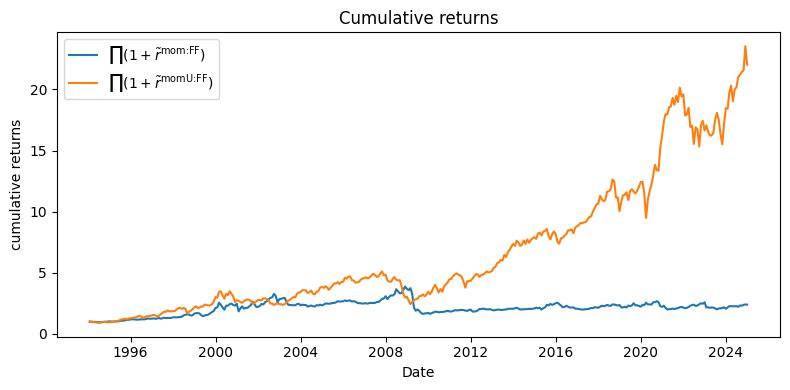

In [6]:
#Question 2.2 d)
subset_5['Date'] = pd.to_datetime(subset_5['Date'], errors='coerce')
subset_4['Date'] = pd.to_datetime(subset_4['Date'], errors='coerce')

long_short = subset_5.set_index('Date')['UMD'].sort_index()
long_only  = subset_4.set_index('Date')['UFF'].sort_index()
long_short, long_only = long_short.align(long_only, join='inner')

cum_ls = (1 + long_short).cumprod()
cum_lo = (1 + long_only).cumprod()

plt.figure(figsize=(8,4))
plt.plot(cum_ls, label=r"$\prod (1+\tilde r^{\text{mom:FF}})$")
plt.plot(cum_lo, label=r"$\prod (1+\tilde r^{\text{momU:FF}})$")
plt.legend()
plt.title("Cumulative returns")
plt.xlabel("Date")
plt.ylabel("cumulative returns")
plt.tight_layout()
plt.show()

### 2.3. 
Is momentum just data mining, or is it a robust strategy?

Assess how sensitive the threshold for the “winners” and “losers” is in the results. Specifically, we compare three constructions:

- long the top 1 decile and short the bottom 1 deciles:

$$ \tilde{r}^{momD1} = r^{mom(10)} - r^{mom(1)}$$

- long the top 3 deciles and short the bottom 3 deciles:

$$ 
\begin{aligned}
\tilde{r}^{momD3} &= \frac{1}{3}(r^{mom(8)} + r^{mom(9)} + r^{mom(10)}) - \frac{1}{3} (r^{mom(3)} + r^{mom(2)} + r^{mom(1)})\\
&= \frac{1}{3}\sum_{k = 8}^{10} r^{mom(k)} - \frac{1}{3}\sum_{k = 1}^{3} r^{mom(k)} 
\end{aligned}$$

- long the top 5 deciles and short the bottom 5 decile:

$$ \tilde{r}^{momD5} = \frac{1}{5}\sum_{k = 6}^{10} r^{mom(k)} - \frac{1}{5}\sum_{k = 1}^{5} r^{mom(k)} $$

#### (a) 
Compare all three constructions, (in the full-sample period,) by filling out the stats in the table below for the period 1994-2023.

$$
\begin{equation}
\begin{aligned}
&\text { Table 3: Robustness of momentum construction. }\\
&\begin{array}{lllllll}
\hline \hline \text { 1994-2024 } \quad \text { mean } & \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline \tilde{r}^{\text {momD1 }} & & & & & \\
\tilde{r}^{\text {momD3 }} & & & & \\
\tilde{r}^{\text {momD5 }} & & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation}
$$

#### (b) 
Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?

#### (c) 
Should AQR's retail product consider using a 1-decile or 5-decile construction?

#### (d) 
Does $\tilde{r}^{\text {momD3 }}$ have similar stats to the Fama-French construction in (1). Recall that construction is also a 3-decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table 2.

In [7]:
#Question 2.3 a)

#reading file
sheet_deciles='deciles (total returns)'

df_deciles=pd.read_excel(path, sheet_deciles)

df_deciles['Date'] = pd.to_datetime(df_deciles['Date'], errors='coerce')

#calculating constructions
df_deciles['r_mom_d1']=df_deciles['Hi PRIOR']-df_deciles['Lo PRIOR']

hi = df_deciles[['Hi PRIOR', 'PRIOR 9', 'PRIOR 8']].mean(axis=1)
lo = df_deciles[['Lo PRIOR', 'PRIOR 2', 'PRIOR 3']].mean(axis=1)
df_deciles['r_mom_d3'] = hi - lo

hi = df_deciles[['Hi PRIOR', 'PRIOR 9', 'PRIOR 8', 'PRIOR 7', 'PRIOR 6']].mean(axis=1)
lo = df_deciles[['Lo PRIOR', 'PRIOR 2', 'PRIOR 3', 'PRIOR 4', 'PRIOR 5']].mean(axis=1)
df_deciles['r_mom_d5'] = hi - lo

#merging factors
df_deciles=df_deciles.merge(df_factors, on='Date', how='left')

#calculating summary statistics 
m4 = (date.dt.year >= 1994) & (date.dt.year <= 2024)
df_deciles_subset=df_deciles.loc[m4]


df_summary_d1=calc_summary_statistics(df_deciles_subset, target_col="r_mom_d1")
df_summary_d3=calc_summary_statistics(df_deciles_subset, target_col="r_mom_d3")
df_summary_d5=calc_summary_statistics(df_deciles_subset, target_col="r_mom_d5")

df_all = pd.concat([df_summary_d1, df_summary_d3, df_summary_d5], axis=0)

# set the two index values (rows)
df_all.index = [
    r"R_mom_D1",
    r"R_mom_D3",
    r"R_mom_D5"
]

# set the index *name* (the header over the index column)
df_all.index.name = "1994–2024"

#print
df_all.round(3)


,Mean,Vol,Sharpe,Skew,Corr(MKT),Corr(HML)
1994–2024,,,,,,
R_mom_D1,0.081,0.300,0.270,-1.301,-0.324,-0.237
R_mom_D3,0.030,0.194,0.154,-1.341,-0.363,-0.212
R_mom_D5,0.017,0.134,0.129,-1.421,-0.354,-0.209


Question 2.3 b)

Yes, the tradeoffs line up with theory. D1 has the largest mean, but also the highest volatility and most negative skew; meanwhile, D5 is the most diversified, so the mean dilutes and volatility drops. Finally, D3 lands in-between and delivers the best Sharpe.

Question 2.3 c)

For a retail product, I would preffer D5. D1’s higher average return comes with much worse tail risk and higher volatility. On the other hand, D5 offers a smoother ride and still negative correlations to other statistical factors, which improves portfolio diversification even if standalone mean is lower. Moreover, if it going to be for the mutual fund then they should consider the one with the lowest risk due to regulations.

Question 2.3 d)

It is broadly similar to the FF 3-decile long-short. The correlations to the factors are likewise modestly negative. In the analysed sample, D3 shows a higher mean but also higher volatility, yielding a slightly lower Sharpe than the FF construction. So they tell a consistent story, with small implementation-driven differences.

### 2.4. 
Does implementing momentum require trading lots of small stocks-- thus causing even larger trading costs?

For regulatory and liquidity reasons, AQR is particularly interested in using larger stocks for their momentum baskets. (Though they will launch one product that focuses on medium-sized stocks.)

Use the data provided on both small-stock “winners”, $r^{momSU}$, and small-stock “losers”, $r^{momSD}$, to construct a small-stock momentum portfolio,

$$ r^{momS}_t = r^{momSU}_t - r^{momSD}_t $$

Similarly, use the data provided to construct a big-stock momentum portfolio,

$$ r^{momB}_t = r^{momBU}_t − r^{momBD}_t $$

#### (a) 
Fill out Table 4 over the sample 1994-2024.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 4: Momentum of small and big stocks. }\\
&\begin{array}{llllll}
\hline \hline \text { 1994-2024 } & \text { mean } & \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}[m] \\
\hline \hline \text { All stocks, } \tilde{r}^{\text {mom:FF }} & & & & \\
\text { Small stocks } r_t^{\text {mom } S} & & & \\
\text { Large stocks } r_t^{\text {mom } B} & & & \\
\hline
\end{array}
\end{aligned}
\end{equation*}
$$

#### (b) 
Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

In [9]:
#question 2.4 a)
sheet_last='size_sorts (total returns)'

df_last=pd.read_excel(path, sheet_last)
m4 = (date.dt.year >= 1994) & (date.dt.year <= 2024)
df_last_subset=df_last.loc[m4]
df_last_subset['mom_S']=df_last_subset['SMALL HiPRIOR']-df_last_subset['SMALL LoPRIOR']
df_last_subset['mom_B']=df_last_subset['BIG HiPRIOR']-df_last_subset['BIG LoPRIOR']

#merging factors
df_last_subset=df_last_subset.merge(df_factors, on='Date', how='left')

df_summary_mom_S=calc_summary_statistics(df_last_subset, target_col="mom_S")
df_summary_mom_B=calc_summary_statistics(df_last_subset, target_col="mom_B")

df_all = pd.concat([df_summary_2, df_summary_mom_S, df_summary_mom_B], axis=0)

# set the two index values (rows)
df_all.index = [
    r"All Stocks",
    r"Small Stocks",
    r"Big Stocks"
]

# set the index *name* (the header over the index column)
df_all.index.name = "1994–2024"

#print
df_all.round(3)

C:\Users\gonza\AppData\Local\Temp\ipykernel_16168\1581497673.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_subset['mom_S']=df_last_subset['SMALL HiPRIOR']-df_last_subset['SMALL LoPRIOR']
C:\Users\gonza\AppData\Local\Temp\ipykernel_16168\1581497673.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_subset['mom_B']=df_last_subset['BIG HiPRIOR']-df_last_subset['BIG LoPRIOR']


,Mean,Vol,Sharpe,Skew,Corr(MKT),Corr(HML)
1994–2024,,,,,,
All Stocks,0.043,0.167,0.257,-1.461,-0.311,-0.210
Small Stocks,0.061,0.169,0.363,-1.804,-0.310,-0.139
Big Stocks,0.025,0.182,0.135,-0.874,-0.282,-0.257


2.4 b)

Small stocks drive more of the appeal. They show a higher mean and Sharpe versus big stocks. So momentum is stronger in small caps, but large-cap momentum is still positive, although it is weaker and at a slightly higher risk.

### 2.5. 
In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?

2.5 

Overall, the AQR retail momentum sleeve captures the core features of Fama–French momentum. It delivers positive average returns pre-2009, improves the efficient frontier via low or negative correlation to the market and value, and remains effective across size buckets. That said, recent decades show weaker standalone performance.